In [4]:
from Solvers import adv_solver, span_solver
from Adversary import Adversary, Problem
import numpy as np
import matplotlib.pyplot as plt
import itertools
from Examples import exact_k, threshold_k

In [45]:
class SpanProgram():
    def __init__(self, problem, I_dict):
        self.target = np.ones(problem.no_len)
        self.num_vects = np.sum([len(v) for i, v in I_dict.items()])
        self.ordered_I = [pair for pair in itertools.product(tuple(range(problem.n)), problem.alphabet)]
        self.I_to_mat = {}
        self.counter = 0
        self.vect_list = []
        self.ticks = []
        for pair, v_set in I_dict.items():
            self.ticks.append(self.counter)
            self.I_to_mat[pair] = list(range(self.counter, self.counter + len(v_set)))
            self.counter += len(v_set)
            self.vect_list.append(*v_set)
            
        
        self.A = np.block(self.vect_list).T 
    
    def visualize_A(self):
        plt.imshow(self.A)
        plt.xticks(self.ticks, self.ordered_I)
        plt.colorbar()
        plt.show()
                
        

In [48]:
sp = SpanProgram(exact_k(2,1), 
            {
            (0,0): [[0]],
            (0,1): [[1]],
            (1,0): [[0]],
            (1,1): [[1]]
                          })



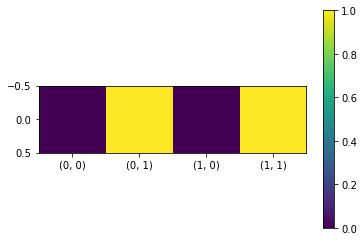

In [49]:
sp.visualize_A()

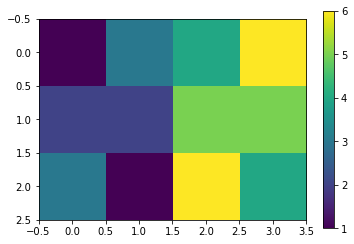

In [24]:
S.